In [146]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats


import unicodedata
import markdown
import re
import nltk
import os
import prepare as p
import preprocess as pre

from requests import get
from bs4 import BeautifulSoup

from nltk.tokenize.toktok import ToktokTokenizer
from nltk.corpus import stopwords
from wordcloud import WordCloud

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report


In [2]:
# Here I read in a csv file with all the data we acquired using api
df = pd.read_csv('all_repos.csv')

In [3]:
# These are null values we identified
df.iloc[686]

repo               mattwaite/NICAR19SportsDataViz
language                                      NaN
readme_contents                               NaN
Name: 686, dtype: object

In [4]:
# All null values in our data
df.isnull().sum()

repo                0
language           72
readme_contents     1
dtype: int64

In [5]:
# I decided to drop all since it makes up a small portion of our data
df.dropna(inplace = True)

In [6]:
df = df[df.readme_contents != 'failedreadme']

In [7]:
# This is what is left after dropping all nulls
df.shape

(883, 3)

In [8]:
# Quick look at our data
df.head()

,repo,language,readme_contents
0,ScottfreeLLC/AlphaPy,Python,AlphaPy\n=======\n\n|badge_pypi| |badge_downlo...
1,jalapic/engsoccerdata,R,"Latest GitHub version: 11/4/2022, v0.1.7\n\nN..."
2,bttmly/nba,JavaScript,# nba\n*Node.js client for nba.com API endpoin...
3,kyleskom/NBA-Machine-Learning-Sports-Betting,Python,# NBA Sports Betting Using Machine Learning 🏀\...
4,linouk23/NBA-Player-Movements,Python,# NBA Player Movements\n\nThis is a script for...


In [9]:
# Count of all the languages that appear
df.language.value_counts()

Python               232
JavaScript           141
Jupyter Notebook      86
R                     43
TypeScript            40
HTML                  40
Java                  39
PHP                   35
Ruby                  30
C#                    24
C++                   22
Dart                  22
Kotlin                20
CSS                   19
Vue                   10
Objective-C           10
Swift                 10
Go                     9
Rust                   6
XSLT                   4
TeX                    3
Shell                  3
Solidity               3
C                      3
Elixir                 3
CoffeeScript           2
MATLAB                 2
Visual Basic .NET      2
Svelte                 2
EJS                    2
Matlab                 2
Scala                  2
Haskell                1
Stata                  1
Visual Basic           1
Haxe                   1
Dockerfile             1
XML                    1
Max                    1
Batchfile              1


# Many of these are not commonly used and some are not actual program languages. I need to either remove or categorize some of these into 'other'

In [10]:
# I created a list of all actual languages and filtered my data to only include the languages in my list. 
# This should reduce the number of observations and change the shape of my dataframe

valid_languages = ["Python", 'HTML', "JavaScript", "R", "Java", "TypeScript", "PHP", "Ruby", "C#", "C++", "Dart", "Kotlin", "Objective-C", "Swift", "Go", "Rust", "C", "Elixir", "CoffeeScript", "MATLAB", "Visual Basic .NET", "Scala", "Haskell", "Stata", "Haxe", "Lua", "Perl", "Clojure"]

# Use the isin method to filter the DataFrame
df = df[df['language'].isin(valid_languages)]

df.head()


,repo,language,readme_contents
0,ScottfreeLLC/AlphaPy,Python,AlphaPy\n=======\n\n|badge_pypi| |badge_downlo...
1,jalapic/engsoccerdata,R,"Latest GitHub version: 11/4/2022, v0.1.7\n\nN..."
2,bttmly/nba,JavaScript,# nba\n*Node.js client for nba.com API endpoin...
3,kyleskom/NBA-Machine-Learning-Sports-Betting,Python,# NBA Sports Betting Using Machine Learning 🏀\...
4,linouk23/NBA-Player-Movements,Python,# NBA Player Movements\n\nThis is a script for...


In [11]:
# Another look at the count of each language that appear.
df.language.value_counts()

Python               232
JavaScript           141
R                     43
TypeScript            40
HTML                  40
Java                  39
PHP                   35
Ruby                  30
C#                    24
Dart                  22
C++                   22
Kotlin                20
Swift                 10
Objective-C           10
Go                     9
Rust                   6
C                      3
Elixir                 3
Visual Basic .NET      2
MATLAB                 2
CoffeeScript           2
Scala                  2
Perl                   1
Lua                    1
Haskell                1
Haxe                   1
Stata                  1
Clojure                1
Name: language, dtype: int64

# I was able to remove all that were not actual languages. Now I need to categorize the remaining into five categories

In [12]:
# Quick look at the total of languages that appear less than 40 times
df.language.value_counts()[df.language.value_counts() < 40].sum()

247

# Since I am keeping the top four languages as is and placing the rest into 'other' category, I should end up with a count total of 287 for 'other' because both html and typescript have the same total count

In [13]:
# List of languages to rename to 'other'
languages_to_rename = ['HTML', 'Java', 'PHP', 'Ruby', 'C#', 'C++', 'Dart', 'Kotlin', 'Objective-C', 'Swift', 'Go', 'Rust', 'C', 'Elixir', 'Visual Basic .NET', 'MATLAB', 'CoffeeScript', 'Scala', 'Perl', 'Lua', 'Haskell', 'Haxe', 'Stata', 'Clojure']

# Replace the specified languages with 'other'
df['language'] = df['language'].replace(languages_to_rename, 'other')


In [14]:
# Quick look at total count of each language to verify accurate count
df.language.value_counts()

other         287
Python        232
JavaScript    141
R              43
TypeScript     40
Name: language, dtype: int64

In [15]:
# Here I concat two series together which outputs the count for each language appearance and the porportion it make up
labels = pd.concat([df.language.value_counts(),
                    df.language.value_counts(normalize=True)], axis=1)
labels.columns = ['n', 'percent']
labels

,n,percent
other,287,0.386272
Python,232,0.312248
JavaScript,141,0.189771
R,43,0.057873
TypeScript,40,0.053836


# R and Typscript make up a vary small proportion. This will make it difficult for my models to predict accuratley. Maybe I should add those two the the 'other' category

In [16]:
# The data I am left with
df.shape

(743, 3)

In [17]:
type(' '.join(df[df.language == 'Python']['readme_contents']))

str

# Clean

In [18]:
# Here I call my advanced clean function on my data filtered by each type of language and its 
# corresponding readme contents then split in to a list of words
python_words = p.advanced_clean(' '.join(df[df.language == 'Python']['readme_contents']), l = True, extra_words = ['python','eww','sport','data', 'team', 'game', 'season', 'league', 'player', 'ball', 'r', 'javascript', 'typescript','html', "javascript", "r", "java", "php", "ruby", "c#", "c++", "dart", "kotlin", "objective-c", "swift", "go", "rust", "c", "elixir", "coffeescript", "matlab", "visual basic .net", "scala", "haskell", "stata", "haxe", "lua", "perl", "clojure" ]).split()
javascript_words = p.advanced_clean(' '.join(df[df.language == 'JavaScript']['readme_contents']), l = True, extra_words = ['python','eww','sport','data', 'team', 'game', 'season', 'league', 'player', 'ball', 'r', 'javascript', 'typescript','html', "javascript", "r", "java", "php", "ruby", "c#", "c++", "dart", "kotlin", "objective-c", "swift", "go", "rust", "c", "elixir", "coffeescript", "matlab", "visual basic .net", "scala", "haskell", "stata", "haxe", "lua", "perl", "clojure" ]).split()
r_words = p.advanced_clean(' '.join(df[df.language == 'R']['readme_contents']), l = True, extra_words = ['python','eww','sport','data', 'team', 'game', 'season', 'league', 'player', 'ball', 'r', 'javascript', 'typescript','html', "javascript", "r", "java", "php", "ruby", "c#", "c++", "dart", "kotlin", "objective-c", "swift", "go", "rust", "c", "elixir", "coffeescript", "matlab", "visual basic .net", "scala", "haskell", "stata", "haxe", "lua", "perl", "clojure" ]).split()
typescript_words = p.advanced_clean(' '.join(df[df.language == 'TypeScript']['readme_contents']), l = True, extra_words = ['python','eww','sport','data', 'team', 'game', 'season', 'league', 'player', 'ball', 'r', 'javascript', 'typescript','html', "javascript", "r", "java", "php", "ruby", "c#", "c++", "dart", "kotlin", "objective-c", "swift", "go", "rust", "c", "elixir", "coffeescript", "matlab", "visual basic .net", "scala", "haskell", "stata", "haxe", "lua", "perl", "clojure" ]).split()
other_words = p.advanced_clean(' '.join(df[df.language == 'other']['readme_contents']), l = True, extra_words = ['python','eww','sport','data', 'team', 'game', 'season', 'league', 'player', 'ball', 'r', 'javascript', 'typescript','html', "javascript", "r", "java", "php", "ruby", "c#", "c++", "dart", "kotlin", "objective-c", "swift", "go", "rust", "c", "elixir", "coffeescript", "matlab", "visual basic .net", "scala", "haskell", "stata", "haxe", "lua", "perl", "clojure" ]).split()
all_words = p.advanced_clean(' '.join(df.readme_contents), l = True, extra_words = ['python','eww','sport','data', 'team', 'game', 'season', 'league', 'player', 'ball', 'r', 'javascript', 'typescript','html', "javascript", "r", "java", "php", "ruby", "c#", "c++", "dart", "kotlin", "objective-c", "swift", "go", "rust", "c", "elixir", "coffeescript", "matlab", "visual basic .net", "scala", "haskell", "stata", "haxe", "lua", "perl", "clojure" ]).split()

Removed 36629 stopwords
---
Removed 22574 stopwords
---
Removed 6369 stopwords
---
Removed 6455 stopwords
---
Removed 23270 stopwords
---
Removed 76877 stopwords
---


In [19]:
len(python_words), len(javascript_words), len(r_words), len(typescript_words), len(other_words), len(all_words)

(67256, 44129, 10998, 10773, 49600, 150346)

In [20]:
# The results is a list of words
type(python_words)


list

In [21]:
# Here I create a series out of my list of words and get the total count for each unique word
python_freq = pd.Series(python_words).value_counts()
javascript_freq = pd.Series(javascript_words).value_counts()
r_freq = pd.Series(r_words).value_counts()
typescript_freq = pd.Series(typescript_words).value_counts()
other_freq = pd.Series(other_words).value_counts()
all_freq = pd.Series(all_words).value_counts()

In [22]:
# Frequency for all unique words in readme's using python
python_freq

barry                                                                           746
file                                                                            510
bee                                                                             361
install                                                                         321
vanessa                                                                         310
                                                                               ... 
targeted                                                                          1
termshumanlossacknowledgementacknowledgementreferencereferencecontactcontact      1
interpolationvideoframeinterpolationhumanaware                                    1
datasetdatasetrequirementsrequirementsvideo                                       1
cvnlpendterm                                                                      1
Length: 13903, dtype: int64

In [23]:
# Frequency for all unique words in readme's using javascript
javascript_freq

get            263
example        229
sport          210
user           207
api            205
              ... 
musicreggae      1
musicrb          1
musicopera       1
musicnewage      1
printed          1
Length: 9305, dtype: int64

In [24]:
# Frequency for all unique words in readme's using R
r_freq

package        95
function       89
model          68
odds           60
result         55
               ..
lastest         1
tanaka          1
lampard         1
compared        1
sourcemainr     1
Length: 3779, dtype: int64

In [25]:
# Frequency for all unique words in readme's using typescript
typescript_freq

run                                               121
app                                                79
import                                             77
use                                                71
file                                               70
                                                 ... 
stripesecretkeyexamplesecretkey                     1
nextpublicstripepublishablekeyexmaplepublickey      1
pagesapicheckoutsessions                            1
located                                             1
moscow                                              1
Length: 3199, dtype: int64

In [26]:
# Frequency for all unique words in readme's using other
other_freq

get                  1208
database              356
point                 275
file                  234
sport                 230
                     ... 
showcase                1
asianoddsplacebet       1
192                     1
1297190352              1
optionally              1
Length: 10655, dtype: int64

In [27]:
# Frequency for all unique words
all_freq

file                               904
barry                              746
sport                              681
get                                660
use                                645
                                  ... 
seasonncaagetdivisions               1
getsportdivisiondatasport            1
examplezipfileconversionexample      1
nonencrypted                         1
replicated                           1
Length: 26442, dtype: int64

In [28]:
type(python_freq)

pandas.core.series.Series

In [29]:
# Quick look at the total amount of unique words in each list
len(python_freq), len(javascript_freq), len(r_freq), len(typescript_freq), len(other_freq), len(all_freq)

(13903, 9305, 3779, 3199, 10655, 26442)

In [30]:
len(python_freq[python_freq < 50])

13694

# Majority of the words occur less than 50 times. I think I will remove this words since they dont have any significance

In [31]:
# Here I filter out all the words fir each list that occur more than 50 times
python_freq = python_freq[python_freq > 50]
javascript_freq = javascript_freq[javascript_freq > 50]
r_freq = r_freq[r_freq > 10]
typescript_freq = typescript_freq[typescript_freq > 10]
other_freq = other_freq[other_freq > 50]
all_freq = all_freq[all_freq > 50]

len(python_freq), len(javascript_freq), len(r_freq), len(typescript_freq), len(other_freq), len(all_freq)

(201, 118, 166, 200, 148, 514)

# Removing those words siginificantly reduced the total amount of words in each list. But this is the frequency. I need to apply to same method to the actual words.

In [32]:
type(python_words)

list

In [33]:
# Here I create a list of extra words I want to remove from each list of words

extra_words1 = (pd.Series(python_words).value_counts()[pd.Series(python_words).value_counts() < 51]).index.values
extra_words2 = (pd.Series(javascript_words).value_counts()[pd.Series(javascript_words).value_counts() < 51]).index
extra_words3 = (pd.Series(r_words).value_counts()[pd.Series(r_words).value_counts() < 51]).index
extra_words4 = (pd.Series(typescript_words).value_counts()[pd.Series(typescript_words).value_counts() < 51]).index
extra_words5 = (pd.Series(other_words).value_counts()[pd.Series(other_words).value_counts() < 51]).index

In [34]:
extra_words = ['python','python3', 'eww','sport','data', 'team', 'game', 'season', 'league', 'player', 'ball', 'r', 'javascript', 'typescript','html', "javascript", "r", "java", "php", "ruby", "c#", "c++", "dart", "kotlin", "objective-c", "swift", "go", "rust", "c", "elixir", "coffeescript", "matlab", "visual basic .net", "scala", "haskell", "stata", "haxe", "lua", "perl", "clojure" ]

In [35]:
# Here I rejoin my words so that I can add extra words to my stopword list
python_words = ' '.join(python_words)
javascript_words = ' '.join(javascript_words)
r_words = ' '.join(r_words)
typescript_words = ' '.join(typescript_words)
other_words = ' '.join(other_words)

In [36]:
# Here I remove the words from the list i created above
python_words = p.remove_stopwords(python_words, extra_words = extra_words1)
javascript_words = p.remove_stopwords(javascript_words, extra_words = extra_words2)
r_words = p.remove_stopwords(r_words, extra_words = extra_words3)
typescript_words = p.remove_stopwords(typescript_words, extra_words = extra_words4)
other_words = p.remove_stopwords(other_words, extra_words = extra_words5)

Removed 46337 stopwords
---
Removed 32805 stopwords
---
Removed 10471 stopwords
---
Removed 9840 stopwords
---
Removed 34491 stopwords
---


In [37]:
# Here I remove the words from the list i created above
python_words = p.remove_stopwords(python_words, extra_words = extra_words).split()
javascript_words = p.remove_stopwords(javascript_words, extra_words = extra_words).split()
r_words = p.remove_stopwords(r_words, extra_words = extra_words).split()
typescript_words = p.remove_stopwords(typescript_words, extra_words = extra_words).split()
other_words = p.remove_stopwords(other_words, extra_words = extra_words).split()

Removed 697 stopwords
---
Removed 413 stopwords
---
Removed 52 stopwords
---
Removed 0 stopwords
---
Removed 513 stopwords
---


In [38]:
type(python_words)

list

In [39]:
# Quick look at the total words i am left with
len(python_words), len(javascript_words), len(r_words), len(typescript_words), len(other_words), len(all_words)

(20222, 10911, 475, 933, 14596, 150346)

# Should I remove all duplicates?

In [40]:
len(pd.unique(python_words))

196

# Actually I need all words to get the frequency of each word

In [41]:
# Quick look at all the bigrams in this list of words
list(nltk.bigrams(python_words))

[('machine', 'library'),
 ('library', 'well'),
 ('well', 'package'),
 ('package', 'feature'),
 ('feature', 'run'),
 ('run', 'machine'),
 ('machine', 'model'),
 ('model', 'using'),
 ('using', 'generate'),
 ('generate', 'create'),
 ('create', 'model'),
 ('model', 'event'),
 ('event', 'system'),
 ('system', 'using'),
 ('using', 'image'),
 ('image', 'model'),
 ('model', 'documentation'),
 ('documentation', 'installation'),
 ('installation', 'pip'),
 ('pip', 'installed'),
 ('installed', 'system'),
 ('system', 'see'),
 ('see', 'run'),
 ('run', 'following'),
 ('following', 'command'),
 ('command', 'install'),
 ('install', 'pip'),
 ('pip', 'install'),
 ('install', 'u'),
 ('u', 'installed'),
 ('installed', 'following'),
 ('following', 'create'),
 ('create', 'object'),
 ('object', 'install'),
 ('install', 'command'),
 ('command', 'pip'),
 ('pip', 'install'),
 ('install', 'git'),
 ('git', 'window'),
 ('window', 'user'),
 ('user', 'install'),
 ('install', 'pip'),
 ('pip', 'install'),
 ('install', 

In [42]:
# Quick look at all the bigrams in this list of words
list(nltk.bigrams(javascript_words))

[('nba', 'api'),
 ('api', 'npm'),
 ('npm', 'install'),
 ('install', 'nba'),
 ('nba', 'nba'),
 ('nba', 'application'),
 ('application', 'using'),
 ('using', 'work'),
 ('work', 'work'),
 ('work', 'server'),
 ('server', 'information'),
 ('information', 'application'),
 ('application', 'used'),
 ('used', 'run'),
 ('run', 'server'),
 ('server', 'change'),
 ('change', 'point'),
 ('point', 'nba'),
 ('nba', 'api'),
 ('api', 'number'),
 ('number', 'json'),
 ('json', 'library'),
 ('library', 'api'),
 ('api', 'return'),
 ('return', 'object'),
 ('object', 'name'),
 ('name', 'id'),
 ('id', 'information'),
 ('information', 'method'),
 ('method', 'method'),
 ('method', 'object'),
 ('object', 'object'),
 ('object', 'stats'),
 ('stats', 'j'),
 ('j', 'const'),
 ('const', 'nba'),
 ('nba', 'const'),
 ('const', 'example'),
 ('example', 'api'),
 ('api', 'call'),
 ('call', 'see'),
 ('see', 'test'),
 ('test', 'file'),
 ('file', 'api'),
 ('api', 'change'),
 ('change', 'api'),
 ('api', 'library'),
 ('library', 

In [43]:
# Quick look at all the bigrams in this list of words
list(nltk.bigrams(r_words))

[('function', 'package'),
 ('package', 'function'),
 ('function', 'package'),
 ('package', 'result'),
 ('result', 'result'),
 ('result', 'result'),
 ('result', 'result'),
 ('result', 'result'),
 ('result', 'result'),
 ('result', 'result'),
 ('result', 'result'),
 ('result', 'result'),
 ('result', 'name'),
 ('name', 'result'),
 ('result', 'result'),
 ('result', 'result'),
 ('result', 'result'),
 ('result', 'function'),
 ('function', 'function'),
 ('function', 'result'),
 ('result', 'result'),
 ('result', 'result'),
 ('result', 'function'),
 ('function', 'result'),
 ('result', 'name'),
 ('name', 'name'),
 ('name', 'name'),
 ('name', 'name'),
 ('name', 'name'),
 ('name', 'name'),
 ('name', 'name'),
 ('name', 'package'),
 ('package', 'name'),
 ('name', 'name'),
 ('name', 'result'),
 ('result', 'result'),
 ('result', 'result'),
 ('result', 'name'),
 ('name', 'function'),
 ('function', 'result'),
 ('result', 'package'),
 ('package', 'model'),
 ('model', 'result'),
 ('result', 'package'),
 ('

In [44]:
# Quick look at all the bigrams in this list of words
list(nltk.bigrams(typescript_words))

[('project', 'run'),
 ('run', 'get'),
 ('get', 'project'),
 ('project', 'project'),
 ('project', 'using'),
 ('using', 'app'),
 ('app', 'run'),
 ('run', 'run'),
 ('run', 'run'),
 ('run', 'file'),
 ('file', 'run'),
 ('run', 'run'),
 ('run', 'run'),
 ('run', 'run'),
 ('run', 'run'),
 ('run', 'run'),
 ('run', 'use'),
 ('use', 'get'),
 ('get', 'run'),
 ('run', 'run'),
 ('run', 'run'),
 ('run', 'use'),
 ('use', 'run'),
 ('run', 'run'),
 ('run', 'run'),
 ('run', 'run'),
 ('run', 'run'),
 ('run', 'run'),
 ('run', 'file'),
 ('file', 'run'),
 ('run', 'run'),
 ('run', 'run'),
 ('run', 'app'),
 ('app', 'run'),
 ('run', 'run'),
 ('run', 'run'),
 ('run', 'run'),
 ('run', 'use'),
 ('use', 'use'),
 ('use', 'run'),
 ('run', 'new'),
 ('new', 'use'),
 ('use', 'get'),
 ('get', 'project'),
 ('project', 'create'),
 ('create', 'new'),
 ('new', 'new'),
 ('new', 'create'),
 ('create', 'npm'),
 ('npm', 'create'),
 ('create', 'use'),
 ('use', 'new'),
 ('new', 'new'),
 ('new', 'create'),
 ('create', 'create'),
 (

In [45]:
# Quick look at all the bigrams in this list of words
list(nltk.bigrams(other_words))

[('view', 'json'),
 ('json', 'application'),
 ('application', 'project'),
 ('project', 'page'),
 ('page', 'available'),
 ('available', 'download'),
 ('download', 'github'),
 ('github', 'issue'),
 ('issue', 'page'),
 ('page', 'table'),
 ('table', 'like'),
 ('like', 'like'),
 ('like', 'change'),
 ('change', 'want'),
 ('want', 'download'),
 ('download', 'used'),
 ('used', 'like'),
 ('like', 'app'),
 ('app', 'also'),
 ('also', 'want'),
 ('want', 'also'),
 ('also', 'repository'),
 ('repository', 'like'),
 ('like', 'version'),
 ('version', 'see'),
 ('see', 'use'),
 ('use', 'version'),
 ('version', 'tournament'),
 ('tournament', 'tournament'),
 ('tournament', 'feature'),
 ('feature', 'list'),
 ('list', 'number'),
 ('number', 'use'),
 ('use', 'version'),
 ('version', 'install'),
 ('install', 'version'),
 ('version', 'version'),
 ('version', 'tournament'),
 ('tournament', 'version'),
 ('version', 'first'),
 ('first', 'need'),
 ('need', 'install'),
 ('install', 'command'),
 ('command', 'default'

In [46]:
# Here I concatanate each series side by side and sort the words in alphabetical order to create a dataframe with 
# new column names in integer types
word_counts = (pd.concat([all_freq, other_freq, python_freq, javascript_freq, r_freq, typescript_freq], axis=1, sort=True)
                .set_axis(['all', 'other', 'python', 'javascript', 'r', 'typescript'], axis=1)
                .fillna(0)
                .apply(lambda s: s.astype(int)))

word_counts.tail()

,all,other,python,javascript,r,typescript
yahoo,118,0,53,0,0,0
yarn,0,0,0,0,0,36
year,170,0,0,117,12,0
youre,111,0,79,62,0,0
zip,53,0,0,0,0,0


In [47]:
# Here I sort my dataframe by the python column in descending order
word_counts.sort_values(by='all', ascending=False).head(10)

,all,other,python,javascript,r,typescript
file,904,234,510,171,33,70
barry,746,0,746,0,0,0
sport,681,230,307,210,39,40
get,660,1208,179,263,32,53
use,645,223,281,140,47,71
example,564,108,223,229,41,17
run,553,133,307,151,13,121
api,539,184,199,205,34,63
install,525,122,321,130,32,39
name,470,94,266,99,54,20


In [48]:
# Here I concatenate datframes on top of eachother where each dataframe represents each language filtered
# by word counts equal to 0 then sorted by the next langauge
pd.concat([word_counts[word_counts.python == 0].sort_values(by='javascript').tail(6),
           word_counts[word_counts.javascript == 0].sort_values(by='python').tail(6)])

,all,other,python,javascript,r,typescript
year,170,0,0,117,12,0
kind,154,0,0,126,0,0
group,172,0,0,144,0,0
npm,125,0,0,160,0,58
const,184,0,0,162,0,32
state,231,0,0,172,0,0
pip,144,0,152,0,0,0
de,220,0,155,0,0,32
adam,180,0,180,0,0,0
model,385,86,224,0,68,0


In [49]:
# Here I concatenate datframes on top of eachother where each dataframe represents each language filtered
# by word counts equal to 0 then sorted by the next langauge
pd.concat([word_counts[word_counts.python == 0].sort_values(by='javascript').tail(6),
           word_counts[word_counts.javascript == 0].sort_values(by='python').tail(6),
           word_counts[word_counts.r == 0].sort_values(by='typescript').tail(6),
           word_counts[word_counts.typescript == 0].sort_values(by='r').tail(6),
           word_counts[word_counts.other == 0].sort_values(by='all').tail(6)])

,all,other,python,javascript,r,typescript
year,170,0,0,117,12,0
kind,154,0,0,126,0,0
group,172,0,0,144,0,0
npm,125,0,0,160,0,58
const,184,0,0,162,0,32
state,231,0,0,172,0,0
pip,144,0,152,0,0,0
de,220,0,155,0,0,32
adam,180,0,180,0,0,0
model,385,86,224,0,68,0


(-0.5, 399.5, 199.5, -0.5)

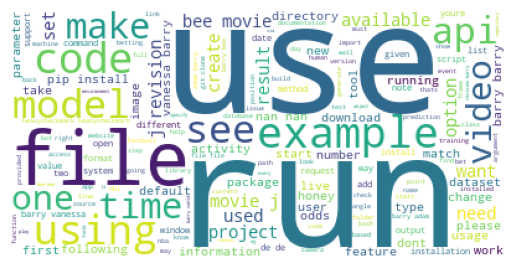

In [50]:
python_img = WordCloud(background_color='white').generate(' '.join (python_words))
# WordCloud() produces an image object, which can be displayed with plt.imshow
plt.imshow(python_img)
# axis aren't very useful for a word cloud
plt.axis('off')

(-0.5, 399.5, 199.5, -0.5)

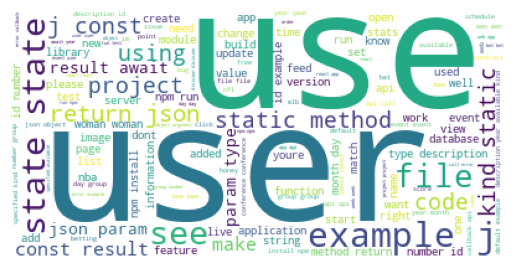

In [51]:
javascript_img = WordCloud(background_color='white').generate(' '.join (javascript_words))
# WordCloud() produces an image object, which can be displayed with plt.imshow
plt.imshow(javascript_img)
# axis aren't very useful for a word cloud
plt.axis('off')

(-0.5, 399.5, 199.5, -0.5)

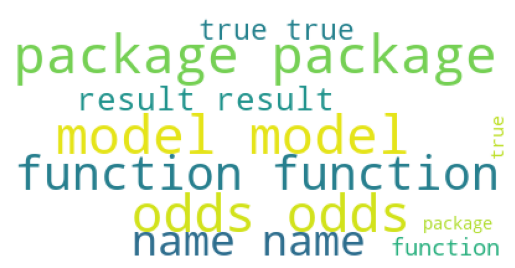

In [52]:
r_img = WordCloud(background_color='white').generate(' '.join (r_words))
# WordCloud() produces an image object, which can be displayed with plt.imshow
plt.imshow(r_img)
# axis aren't very useful for a word cloud
plt.axis('off')

(-0.5, 399.5, 199.5, -0.5)

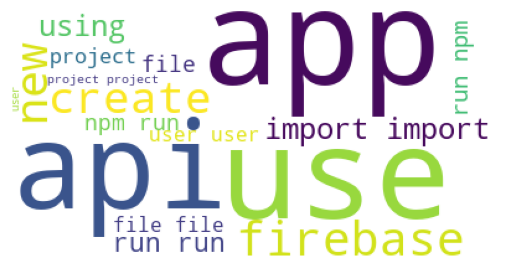

In [53]:
typescript_img = WordCloud(background_color='white').generate(' '.join (typescript_words))
# WordCloud() produces an image object, which can be displayed with plt.imshow
plt.imshow(typescript_img)
# axis aren't very useful for a word cloud
plt.axis('off')

(-0.5, 399.5, 199.5, -0.5)

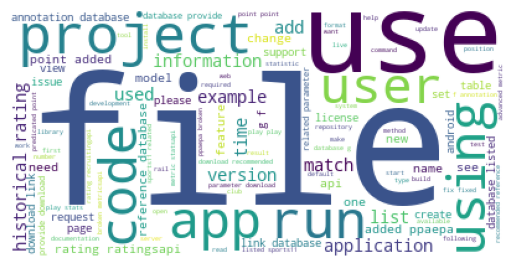

In [54]:
other_img = WordCloud(background_color='white').generate(' '.join (other_words))
# WordCloud() produces an image object, which can be displayed with plt.imshow
plt.imshow(other_img)
# axis aren't very useful for a word cloud
plt.axis('off')

In [55]:
(word_counts.python / word_counts['all']).max()

1.1216216216216217

In [56]:
word_counts.r / word_counts['all']

10       0.000000
100      0.000000
11       0.000000
12       0.207792
15       0.000000
           ...   
yahoo    0.000000
yarn          NaN
year     0.070588
youre    0.000000
zip      0.000000
Length: 615, dtype: float64

Text(0.5, 1.0, 'Proportion of the 20 most common words')

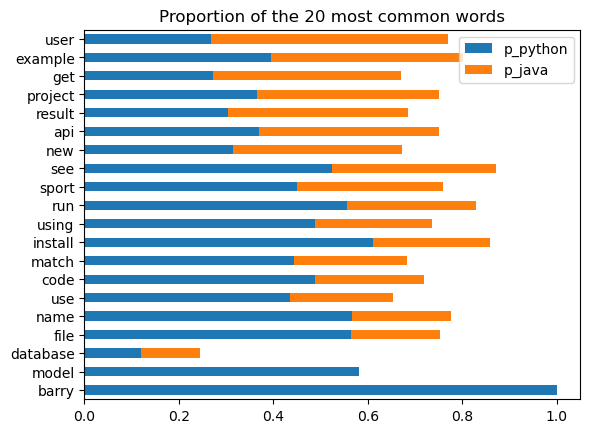

In [57]:

(word_counts
 .assign(p_python=word_counts.python / word_counts['all'],
         p_java=word_counts.javascript / word_counts['all']
        )
 .sort_values(by='all')
 [['p_python', 'p_java']]
 .tail(20)
 .sort_values('p_java')
 .plot.barh(stacked=True))

plt.title('Proportion of the 20 most common words')

Text(0.5, 1.0, 'Proportion of the 20 most common words')

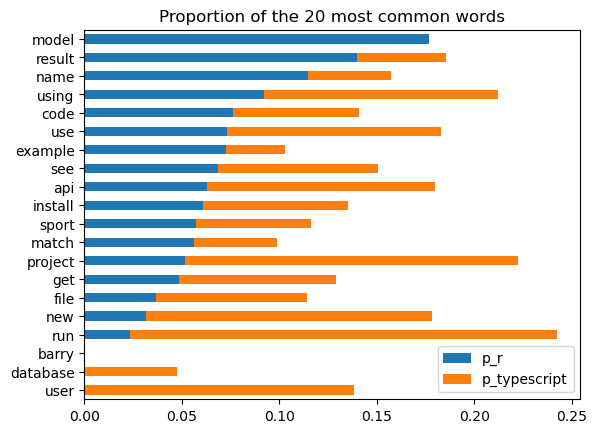

In [58]:

(word_counts
 .assign(p_r=word_counts.r / word_counts['all'],
         p_typescript=word_counts.typescript / word_counts['all']
        )
 .sort_values(by='all')
 [['p_r', 'p_typescript']]
 .tail(20)
 .sort_values('p_r')
 .plot.barh(stacked=True))

plt.title('Proportion of the 20 most common words')

Text(0.5, 1.0, 'Proportion of the 20 most common words')

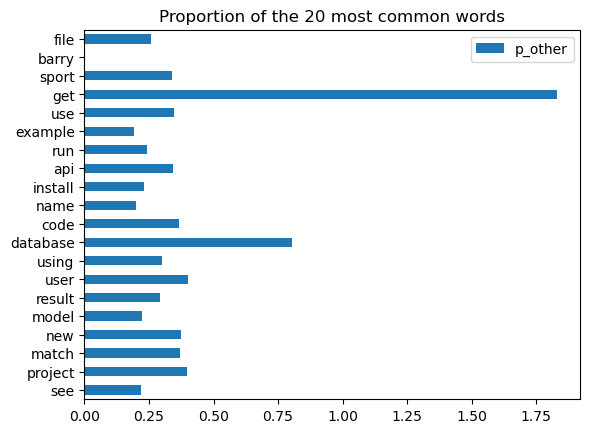

In [59]:

(word_counts
 .assign(p_other=word_counts.other / word_counts['all'])
 .sort_values(by='all')
 [['p_other']]
 .tail(20)

 .plot.barh(stacked=True))

plt.title('Proportion of the 20 most common words')

In [60]:
top_20_python_bigrams = (pd.Series(nltk.ngrams(python_words, 2))
                      .value_counts()
                      .head(20))

top_20_python_bigrams.head(20)

(j, revision)                       131
(movie, j)                          131
(bee, movie)                        131
(revision, 81307)                   122
(pip, install)                      115
(nan, nan)                          103
(vanessa, barry)                     88
(barry, barry)                       88
(barry, vanessa)                     82
(heavycheckmark, heavycheckmark)     67
(de, de)                             64
(file, file)                         58
(barry, adam)                        58
(adam, barry)                        52
(barry, bee)                         51
(git, clone)                         49
(barry, contd)                       46
(bee, bee)                           46
(81307, barry)                       45
(name, name)                         44
dtype: int64

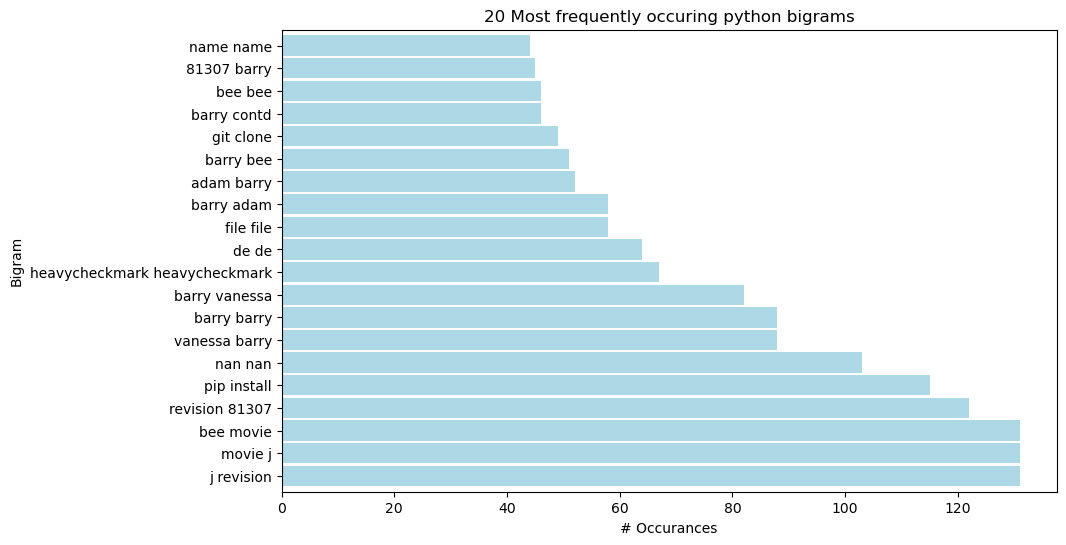

In [61]:
top_20_python_bigrams.sort_values(ascending=False).plot.barh(color='lightblue', width=.9, figsize=(10, 6))

plt.title('20 Most frequently occuring python bigrams')
plt.ylabel('Bigram')
plt.xlabel('# Occurances')

# make the labels pretty
ticks, _ = plt.yticks()
labels = top_20_python_bigrams.reset_index()['index'].apply(lambda t: t[0] + ' ' + t[1])
_ = plt.yticks(ticks, labels)


In [62]:
len(all_words)

150346

In [63]:
len(np.unique(all_words))

26442

In [64]:
df.readme_contents.str.split()

0      [AlphaPy, =======, |badge_pypi|, |badge_downlo...
1      [Latest, GitHub, version:, 11/4/2022,, v0.1.7,...
2      [#, nba, *Node.js, client, for, nba.com, API, ...
3      [#, NBA, Sports, Betting, Using, Machine, Lear...
4      [#, NBA, Player, Movements, This, is, a, scrip...
                             ...                        
989    [trackstatter, ---------, Track, your, Yahoo, ...
990    [#, EventProject, A, project, that, helps, tho...
992    [#, MLB-GameFeed-Bot, Add, to, your, server, w...
993    [#, court-booking-ddd, A, sample, application,...
995    [#, img-captioning-in-vietnamese, ##, Project,...
Name: readme_contents, Length: 743, dtype: object

In [65]:
dictionary = {'barry': 1, 'install': 1}

In [66]:
dictionary.keys()

dict_keys(['barry', 'install'])

In [67]:
if 'random' in dictionary.keys():
    
    dictionary['random'] += 1
    
dictionary

{'barry': 1, 'install': 1}

In [68]:
dictionary['no'] = 1


In [69]:
dictionary

{'barry': 1, 'install': 1, 'no': 1}

# Exploration

## What are the most common words in READMEs?

In [124]:
p = all_freq / len(all_words) * 100

In [125]:
p

file         0.601280
barry        0.496189
sport        0.452955
get          0.438987
use          0.429010
               ...   
framework    0.034587
column       0.034587
either       0.034587
csv          0.033922
fly          0.033922
Length: 514, dtype: float64

In [126]:
n = all_freq

In [128]:
n

file         904
barry        746
sport        681
get          660
use          645
            ... 
framework     52
column        52
either        52
csv           51
fly           51
Length: 514, dtype: int64

In [129]:
# Here I concat two series together which outputs the count for each language appearance and the porportion it make up
labels = pd.concat([n,p], axis = 1)
labels.columns = ['n', 'percent']
labels

,n,percent
file,904,0.601280
barry,746,0.496189
sport,681,0.452955
get,660,0.438987
use,645,0.429010
...,...,...
framework,52,0.034587
column,52,0.034587
either,52,0.034587
csv,51,0.033922


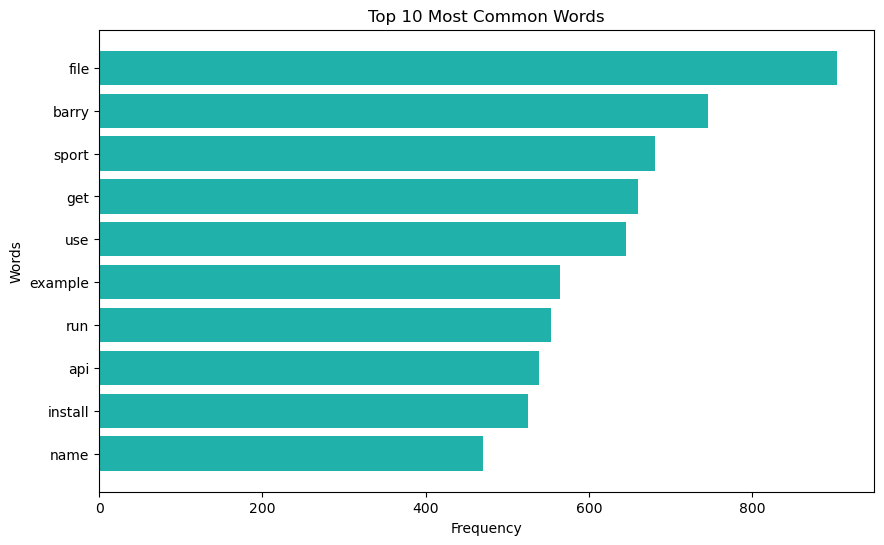

In [179]:
# Sort the dictionary by values in descending order and take the top 10
top_10 = dict(sorted(all_freq.items(), key=lambda item: item[1], reverse=True)[:10])

# Extract words and their frequencies
words = list(top_10.keys())
frequencies = list(top_10.values())

# Create a bar chart
plt.figure(figsize=(10, 6))
plt.barh(words, frequencies, color='lightseagreen')
plt.xlabel('Frequency')
plt.ylabel('Words')
plt.title('Top 10 Most Common Words')
plt.gca().invert_yaxis()  # To display the most common word at the top
plt.show()


## Does the length of the README vary by programming language?

In [132]:
df['readme_length'] = df['readme_contents'].apply(len)
df.head()

,repo,language,readme_contents,clean_text,lemmas,readme_length
0,ScottfreeLLC/AlphaPy,Python,AlphaPy\n=======\n\n|badge_pypi| |badge_downlo...,alphapy badgepypi badgedownloads badgedocs bad...,alphapy badgepypi badgedownloads badgedocs bad...,3158
1,jalapic/engsoccerdata,R,"Latest GitHub version: 11/4/2022, v0.1.7\n\nN...",latest github version 1142022 v017 nov 2022 up...,latest github version 1142022 v017 nov 2022 up...,20310
2,bttmly/nba,JavaScript,# nba\n*Node.js client for nba.com API endpoin...,nba nodejs client nbacom api endpoints npm ins...,nba nodejs client nbacom api endpoint npm inst...,6963
3,kyleskom/NBA-Machine-Learning-Sports-Betting,Python,# NBA Sports Betting Using Machine Learning 🏀\...,nba sports betting using machine learning mach...,nba sport betting using machine learning machi...,2639
4,linouk23/NBA-Player-Movements,Python,# NBA Player Movements\n\nThis is a script for...,nba player movements script visualization nba ...,nba player movement script visualization nba g...,1391


In [134]:
df.shape

(743, 6)

In [162]:
language_stats1 = df.groupby('language')['readme_length'].describe()
print(language_stats1)

            count         mean          std   min      25%     50%      75%  \
language                                                                      
JavaScript  141.0  4491.943262  8084.999544  10.0   799.00  2061.0  4861.00   
Python      232.0  4820.336207  9873.818009  12.0  1096.00  2416.5  4845.75   
R            43.0  4671.813953  6309.711986  41.0   529.50  2275.0  5180.50   
TypeScript   40.0  4038.075000  7634.117122  28.0   870.25  1862.0  4663.75   
other       287.0  3285.045296  6715.110754   8.0   575.00  1681.0  3566.00   

                 max  
language              
JavaScript   61442.0  
Python      113283.0  
R            25461.0  
TypeScript   47470.0  
other        83257.0  


In [142]:
df[df.language == 'Python'].readme_length.mean()

4820.336206896552

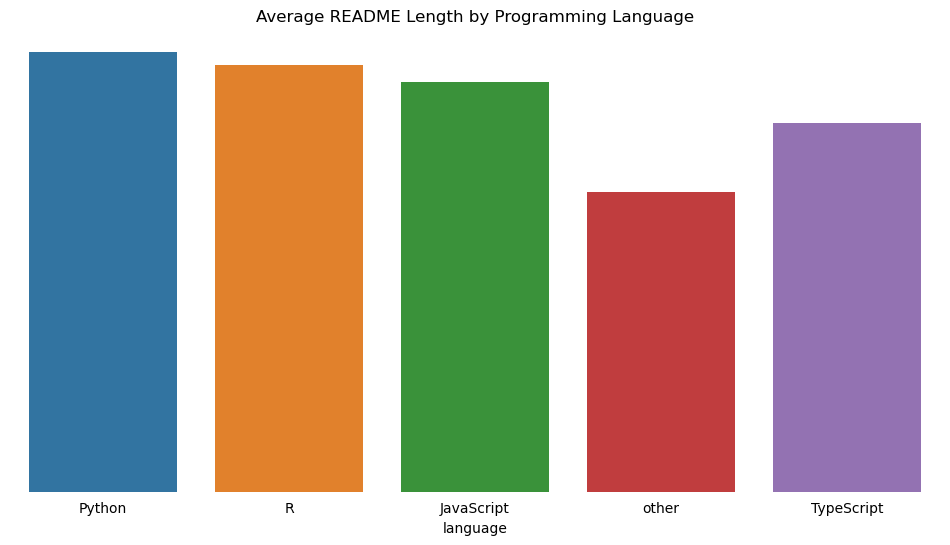

In [182]:
plt.figure(figsize=(12, 6))
ax = sns.barplot(data=df, x='language', y='readme_length', errorbar = None)
ax = plt.gca()

for p in ax.patches:
    value = float(round(p.get_height(), 2)) * 100  # Get the height (value) of each bar

    label = f"{int(round(value))}%" 
        
plt.title('Average README Length by Programming Language')
sns.despine(bottom = True, left = True)
plt.tick_params(axis='x', which='both', bottom=False, top=False)
plt.yticks([])
plt.ylabel('')
plt.show()


In [151]:
from scipy import stats

t_stat, p_value = stats.ttest_ind(df[df.language == 'Python']['readme_length'], df[df.language == 'R']['readme_length'])

print(f't = {t_stat}')
print(f'p = {p_value}')

if p_value < 0.05:
    print(f"Reject the null hypothesis. There is a significant difference between README lengths for Python and R.")

else:
    print(f"Fail to reject the null hypothesis. There is no significant difference between README lengths for Python and R.")


t = 0.09502574731042053
p = 0.9243640869932451
Fail to reject the null hypothesis. There is no significant difference between README lengths for Python and R.


## Do different programming languages use a different number of unique words?

In [158]:
df['unique_word'] = df['clean_text'].apply(lambda x: len(set(x)))
df.head()

,repo,language,readme_contents,clean_text,lemmas,readme_length,tokenized_text,unique_words_count,unique_words,unique_word
0,ScottfreeLLC/AlphaPy,Python,AlphaPy\n=======\n\n|badge_pypi| |badge_downlo...,alphapy badgepypi badgedownloads badgedocs bad...,alphapy badgepypi badgedownloads badgedocs bad...,3158,AlphaPy\n\n\n 124 badge_pypi 124 124 badge_dow...,31,31,72
1,jalapic/engsoccerdata,R,"Latest GitHub version: 11/4/2022, v0.1.7\n\nN...",latest github version 1142022 v017 nov 2022 up...,latest github version 1142022 v017 nov 2022 up...,20310,Latest GitHub version 1142022 v017\n\nNov 20...,37,37,85
2,bttmly/nba,JavaScript,# nba\n*Node.js client for nba.com API endpoin...,nba nodejs client nbacom api endpoints npm ins...,nba nodejs client nbacom api endpoint npm inst...,6963,nba\nNodejs client for nbacom API endpoints\n...,36,36,83
3,kyleskom/NBA-Machine-Learning-Sports-Betting,Python,# NBA Sports Betting Using Machine Learning 🏀\...,nba sports betting using machine learning mach...,nba sport betting using machine learning machi...,2639,NBA Sports Betting Using Machine Learning \ni...,33,33,75
4,linouk23/NBA-Player-Movements,Python,# NBA Player Movements\n\nThis is a script for...,nba player movements script visualization nba ...,nba player movement script visualization nba g...,1391,NBA Player Movements\n\nThis is a script for ...,33,33,70


In [168]:
df[df.language == 'R'].unique_words_count.max()

37

In [163]:
language_stats = df.groupby('language')['unique_words_count'].describe()
print(language_stats)

            count       mean       std   min   25%   50%    75%   max
language                                                             
JavaScript  141.0  28.652482  6.419820   6.0  25.0  29.0  34.00  37.0
Python      232.0  30.193966  6.193235   0.0  26.0  31.5  36.00  37.0
R            43.0  28.860465  7.321142  12.0  24.0  30.0  35.50  37.0
TypeScript   40.0  28.625000  5.031631  11.0  25.0  28.0  31.25  37.0
other       287.0  27.585366  6.810024   0.0  24.0  29.0  32.00  37.0


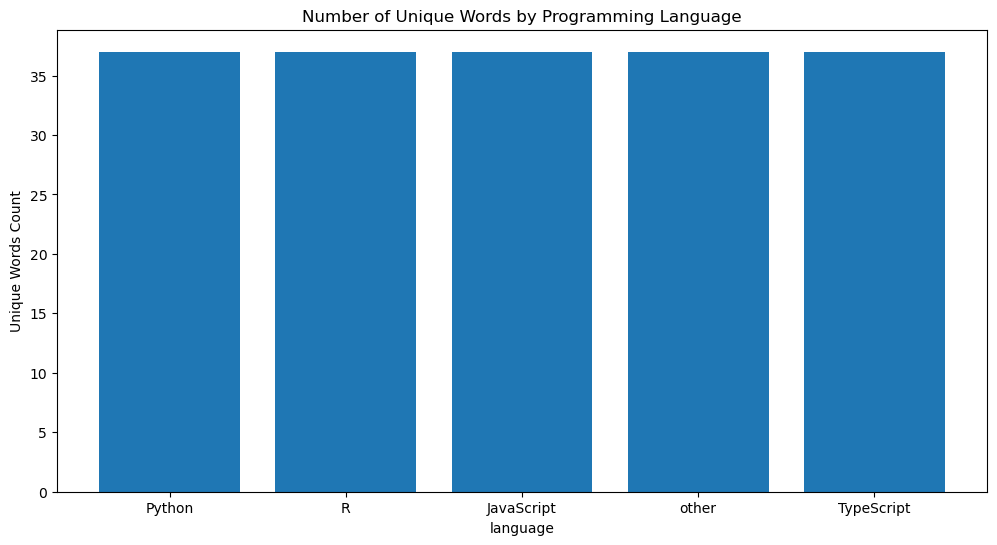

In [164]:
plt.figure(figsize=(12, 6))
plt.bar(df['language'], df['unique_words_count'])
plt.xlabel('language')
plt.ylabel('Unique Words Count')
plt.title('Number of Unique Words by Programming Language')

plt.show()


## Are there any words that uniquely identify a programming language?

In [170]:
df['unique'] = df['clean_text'].apply(lambda x: len(set(x)))
df.head()

,repo,language,readme_contents,clean_text,lemmas,readme_length,tokenized_text,unique_words_count,unique_words,unique_word,unique
0,ScottfreeLLC/AlphaPy,Python,AlphaPy\n=======\n\n|badge_pypi| |badge_downlo...,alphapy badgepypi badgedownloads badgedocs bad...,alphapy badgepypi badgedownloads badgedocs bad...,3158,AlphaPy\n\n\n 124 badge_pypi 124 124 badge_dow...,31,31,72,31
1,jalapic/engsoccerdata,R,"Latest GitHub version: 11/4/2022, v0.1.7\n\nN...",latest github version 1142022 v017 nov 2022 up...,latest github version 1142022 v017 nov 2022 up...,20310,Latest GitHub version 1142022 v017\n\nNov 20...,37,37,85,37
2,bttmly/nba,JavaScript,# nba\n*Node.js client for nba.com API endpoin...,nba nodejs client nbacom api endpoints npm ins...,nba nodejs client nbacom api endpoint npm inst...,6963,nba\nNodejs client for nbacom API endpoints\n...,36,36,83,36
3,kyleskom/NBA-Machine-Learning-Sports-Betting,Python,# NBA Sports Betting Using Machine Learning 🏀\...,nba sports betting using machine learning mach...,nba sport betting using machine learning machi...,2639,NBA Sports Betting Using Machine Learning \ni...,33,33,75,33
4,linouk23/NBA-Player-Movements,Python,# NBA Player Movements\n\nThis is a script for...,nba player movements script visualization nba ...,nba player movement script visualization nba g...,1391,NBA Player Movements\n\nThis is a script for ...,33,33,70,33


In [171]:
df['un'] = df['clean_text'].apply(lambda x: len(set(x)))

df.head()

,repo,language,readme_contents,clean_text,lemmas,readme_length,tokenized_text,unique_words_count,unique_words,unique_word,unique,un
0,ScottfreeLLC/AlphaPy,Python,AlphaPy\n=======\n\n|badge_pypi| |badge_downlo...,alphapy badgepypi badgedownloads badgedocs bad...,alphapy badgepypi badgedownloads badgedocs bad...,3158,AlphaPy\n\n\n 124 badge_pypi 124 124 badge_dow...,31,31,72,31,31
1,jalapic/engsoccerdata,R,"Latest GitHub version: 11/4/2022, v0.1.7\n\nN...",latest github version 1142022 v017 nov 2022 up...,latest github version 1142022 v017 nov 2022 up...,20310,Latest GitHub version 1142022 v017\n\nNov 20...,37,37,85,37,37
2,bttmly/nba,JavaScript,# nba\n*Node.js client for nba.com API endpoin...,nba nodejs client nbacom api endpoints npm ins...,nba nodejs client nbacom api endpoint npm inst...,6963,nba\nNodejs client for nbacom API endpoints\n...,36,36,83,36,36
3,kyleskom/NBA-Machine-Learning-Sports-Betting,Python,# NBA Sports Betting Using Machine Learning 🏀\...,nba sports betting using machine learning mach...,nba sport betting using machine learning machi...,2639,NBA Sports Betting Using Machine Learning \ni...,33,33,75,33,33
4,linouk23/NBA-Player-Movements,Python,# NBA Player Movements\n\nThis is a script for...,nba player movements script visualization nba ...,nba player movement script visualization nba g...,1391,NBA Player Movements\n\nThis is a script for ...,33,33,70,33,33


In [169]:
df['unique_words'] = df['clean_text'].apply(lambda x: len(set(x)))

df.head()

,repo,language,readme_contents,clean_text,lemmas,readme_length,tokenized_text,unique_words_count,unique_words,unique_word
0,ScottfreeLLC/AlphaPy,Python,AlphaPy\n=======\n\n|badge_pypi| |badge_downlo...,alphapy badgepypi badgedownloads badgedocs bad...,alphapy badgepypi badgedownloads badgedocs bad...,3158,AlphaPy\n\n\n 124 badge_pypi 124 124 badge_dow...,31,31,72
1,jalapic/engsoccerdata,R,"Latest GitHub version: 11/4/2022, v0.1.7\n\nN...",latest github version 1142022 v017 nov 2022 up...,latest github version 1142022 v017 nov 2022 up...,20310,Latest GitHub version 1142022 v017\n\nNov 20...,37,37,85
2,bttmly/nba,JavaScript,# nba\n*Node.js client for nba.com API endpoin...,nba nodejs client nbacom api endpoints npm ins...,nba nodejs client nbacom api endpoint npm inst...,6963,nba\nNodejs client for nbacom API endpoints\n...,36,36,83
3,kyleskom/NBA-Machine-Learning-Sports-Betting,Python,# NBA Sports Betting Using Machine Learning 🏀\...,nba sports betting using machine learning mach...,nba sport betting using machine learning machi...,2639,NBA Sports Betting Using Machine Learning \ni...,33,33,75
4,linouk23/NBA-Player-Movements,Python,# NBA Player Movements\n\nThis is a script for...,nba player movements script visualization nba ...,nba player movement script visualization nba g...,1391,NBA Player Movements\n\nThis is a script for ...,33,33,70


In [172]:
contingency_table = pd.crosstab(df['language'], df['unique_words'])


In [175]:
from scipy.stats import chi2_contingency

chi2, p, _, _ = chi2_contingency(contingency_table)

print(f'Chi2 = {chi2}')
print(f'P = {p}')

if p < 0.05:  # Choose your significance level
    print("Reject the null hypothesis. There is an association between programming languages and unique word counts.")
else:
    print("Fail to reject the null hypothesis. There is no significant association.")

Chi2 = 164.9140164408829
P = 0.02752276575233404
Reject the null hypothesis. There is an association between programming languages and unique word counts.


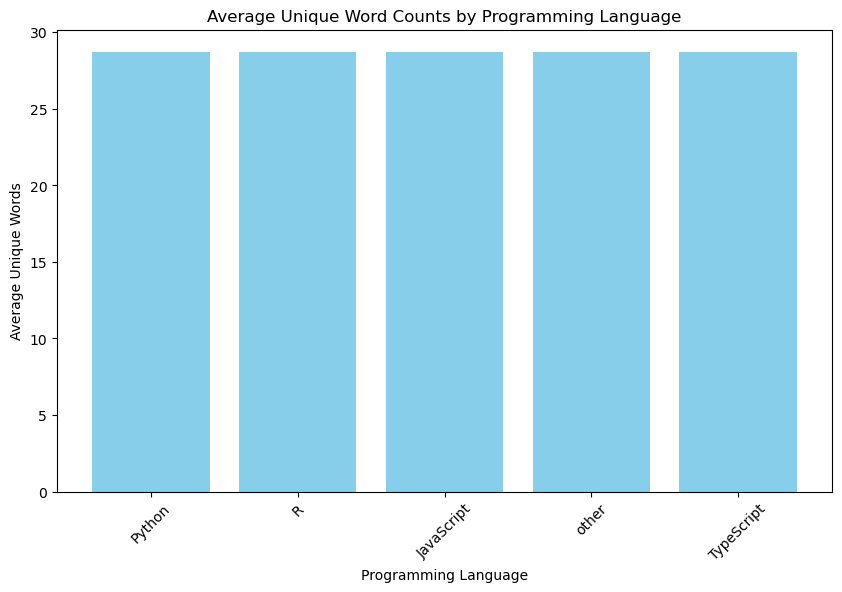

In [176]:
plt.figure(figsize=(10, 6))  # Set the figure size

# Create the bar chart
plt.bar(df['language'], df['unique_words'].mean(), color='skyblue')

# Add labels and title
plt.xlabel('Programming Language')
plt.ylabel('Average Unique Words')
plt.title('Average Unique Word Counts by Programming Language')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Display the chart
plt.show()


# Modeling

In [71]:
df['clean_text'] = df.readme_contents.apply(p.advanced_clean)

Removed 87 stopwords
---
Removed 813 stopwords
---
Removed 293 stopwords
---
Removed 92 stopwords
---
Removed 48 stopwords
---
Removed 951 stopwords
---
Removed 130 stopwords
---
Removed 305 stopwords
---
Removed 20 stopwords
---
Removed 0 stopwords
---
Removed 21 stopwords
---
Removed 20 stopwords
---
Removed 953 stopwords
---
Removed 470 stopwords
---
Removed 878 stopwords
---
Removed 104 stopwords
---
Removed 0 stopwords
---
Removed 62 stopwords
---
Removed 67 stopwords
---
Removed 10 stopwords
---
Removed 177 stopwords
---
Removed 20 stopwords
---
Removed 106 stopwords
---
Removed 62 stopwords
---
Removed 411 stopwords
---
Removed 83 stopwords
---
Removed 608 stopwords
---
Removed 754 stopwords
---
Removed 92 stopwords
---
Removed 48 stopwords
---
Removed 131 stopwords
---
Removed 356 stopwords
---
Removed 3 stopwords
---
Removed 213 stopwords
---
Removed 66 stopwords
---
Removed 69 stopwords
---
Removed 741 stopwords
---
Removed 100 stopwords
---
Removed 187 stopwords
---
Removed 

Removed 685 stopwords
---
Removed 0 stopwords
---
Removed 34 stopwords
---
Removed 1 stopwords
---
Removed 64 stopwords
---
Removed 76 stopwords
---
Removed 5 stopwords
---
Removed 44 stopwords
---
Removed 62 stopwords
---
Removed 100 stopwords
---
Removed 254 stopwords
---
Removed 43 stopwords
---
Removed 0 stopwords
---
Removed 12 stopwords
---
Removed 164 stopwords
---
Removed 63 stopwords
---
Removed 31 stopwords
---
Removed 90 stopwords
---
Removed 124 stopwords
---
Removed 16 stopwords
---
Removed 192 stopwords
---
Removed 7 stopwords
---
Removed 121 stopwords
---
Removed 104 stopwords
---
Removed 32 stopwords
---
Removed 135 stopwords
---
Removed 17 stopwords
---
Removed 59 stopwords
---
Removed 109 stopwords
---
Removed 58 stopwords
---
Removed 674 stopwords
---
Removed 16 stopwords
---
Removed 9 stopwords
---
Removed 4 stopwords
---
Removed 0 stopwords
---
Removed 123 stopwords
---
Removed 1 stopwords
---
Removed 17 stopwords
---
Removed 2 stopwords
---
Removed 45 stopwords
--

Removed 193 stopwords
---
Removed 91 stopwords
---
Removed 1 stopwords
---
Removed 8 stopwords
---
Removed 63 stopwords
---
Removed 118 stopwords
---
Removed 29 stopwords
---


In [72]:
df['lemmas'] = df.readme_contents.apply(p.advanced_clean, l = True)

Removed 87 stopwords
---
Removed 813 stopwords
---
Removed 293 stopwords
---
Removed 92 stopwords
---
Removed 48 stopwords
---
Removed 951 stopwords
---
Removed 130 stopwords
---
Removed 305 stopwords
---
Removed 20 stopwords
---
Removed 0 stopwords
---
Removed 21 stopwords
---
Removed 20 stopwords
---
Removed 953 stopwords
---
Removed 470 stopwords
---
Removed 878 stopwords
---
Removed 104 stopwords
---
Removed 0 stopwords
---
Removed 62 stopwords
---
Removed 67 stopwords
---
Removed 10 stopwords
---
Removed 177 stopwords
---
Removed 20 stopwords
---
Removed 106 stopwords
---
Removed 62 stopwords
---
Removed 411 stopwords
---
Removed 83 stopwords
---
Removed 608 stopwords
---
Removed 754 stopwords
---
Removed 92 stopwords
---
Removed 48 stopwords
---
Removed 131 stopwords
---
Removed 356 stopwords
---
Removed 3 stopwords
---
Removed 213 stopwords
---
Removed 66 stopwords
---
Removed 69 stopwords
---
Removed 741 stopwords
---
Removed 100 stopwords
---
Removed 187 stopwords
---
Removed 

Removed 31 stopwords
---
Removed 90 stopwords
---
Removed 124 stopwords
---
Removed 16 stopwords
---
Removed 192 stopwords
---
Removed 7 stopwords
---
Removed 121 stopwords
---
Removed 104 stopwords
---
Removed 32 stopwords
---
Removed 135 stopwords
---
Removed 17 stopwords
---
Removed 59 stopwords
---
Removed 109 stopwords
---
Removed 58 stopwords
---
Removed 674 stopwords
---
Removed 16 stopwords
---
Removed 9 stopwords
---
Removed 4 stopwords
---
Removed 0 stopwords
---
Removed 123 stopwords
---
Removed 1 stopwords
---
Removed 17 stopwords
---
Removed 2 stopwords
---
Removed 45 stopwords
---
Removed 22 stopwords
---
Removed 91 stopwords
---
Removed 305 stopwords
---
Removed 49 stopwords
---
Removed 100 stopwords
---
Removed 78 stopwords
---
Removed 1 stopwords
---
Removed 1 stopwords
---
Removed 137 stopwords
---
Removed 2 stopwords
---
Removed 49 stopwords
---
Removed 66 stopwords
---
Removed 171 stopwords
---
Removed 278 stopwords
---
Removed 5 stopwords
---
Removed 281 stopwords


Removed 233 stopwords
---
Removed 10 stopwords
---
Removed 160 stopwords
---
Removed 24 stopwords
---
Removed 12 stopwords
---
Removed 69 stopwords
---
Removed 8 stopwords
---
Removed 109 stopwords
---
Removed 147 stopwords
---
Removed 28 stopwords
---
Removed 45 stopwords
---
Removed 31 stopwords
---
Removed 22 stopwords
---
Removed 0 stopwords
---
Removed 193 stopwords
---
Removed 91 stopwords
---
Removed 1 stopwords
---
Removed 8 stopwords
---
Removed 63 stopwords
---
Removed 118 stopwords
---
Removed 29 stopwords
---


In [73]:
df.head()

,repo,language,readme_contents,clean_text,lemmas
0,ScottfreeLLC/AlphaPy,Python,AlphaPy\n=======\n\n|badge_pypi| |badge_downlo...,alphapy badgepypi badgedownloads badgedocs bad...,alphapy badgepypi badgedownloads badgedocs bad...
1,jalapic/engsoccerdata,R,"Latest GitHub version: 11/4/2022, v0.1.7\n\nN...",latest github version 1142022 v017 nov 2022 up...,latest github version 1142022 v017 nov 2022 up...
2,bttmly/nba,JavaScript,# nba\n*Node.js client for nba.com API endpoin...,nba nodejs client nbacom api endpoints npm ins...,nba nodejs client nbacom api endpoint npm inst...
3,kyleskom/NBA-Machine-Learning-Sports-Betting,Python,# NBA Sports Betting Using Machine Learning 🏀\...,nba sports betting using machine learning mach...,nba sport betting using machine learning machi...
4,linouk23/NBA-Player-Movements,Python,# NBA Player Movements\n\nThis is a script for...,nba player movements script visualization nba ...,nba player movement script visualization nba g...


In [74]:
train, val, test = pre.train_val_test(df, strat = 'language', stratify = True)

(520, 5) (111, 5) (112, 5)


In [75]:
train.head()

,repo,language,readme_contents,clean_text,lemmas
769,RaphaelTarita/JavaSportsClub-testengine,other,# JavaSportsClub-testengine\n\nA test engine f...,javasportsclubtestengine test engine sportsclu...,javasportsclubtestengine test engine sportsclu...
298,toddrob99/redball,Python,# redball\nCreated by Todd Roberts\n\nhttps://...,redball created todd roberts redball bot manag...,redball created todd robert redball bot manage...
286,IBM/tjbot-sports-buddy,JavaScript,[![Build Status](https://travis-ci.org/IBM/tjb...,build status watson tjbot tjbot watson discove...,build status watson tjbot tjbot watson discove...
165,GoldenCheetah/scikit-sports,Python,Scikit-sports\n=============\n\n.. image:: htt...,scikitsports image target image target image t...,scikitsports image target image target image t...
309,rakibdevs/covid19-laravel-api,other,## Laravel [Covid 19](https://rapidapi.com/api...,laravel covid 19 api packagist github stars gi...,laravel covid 19 api packagist github star git...


In [76]:
X_train, y_train = pre.xy_split(train)
X_val, y_val = pre.xy_split(val)
X_test, y_test = pre.xy_split(test)

In [77]:
X_train.shape, X_val.shape, X_test.shape

((520, 4), (111, 4), (112, 4))

In [78]:
X_train.head()

,repo,readme_contents,clean_text,lemmas
769,RaphaelTarita/JavaSportsClub-testengine,# JavaSportsClub-testengine\n\nA test engine f...,javasportsclubtestengine test engine sportsclu...,javasportsclubtestengine test engine sportsclu...
298,toddrob99/redball,# redball\nCreated by Todd Roberts\n\nhttps://...,redball created todd roberts redball bot manag...,redball created todd robert redball bot manage...
286,IBM/tjbot-sports-buddy,[![Build Status](https://travis-ci.org/IBM/tjb...,build status watson tjbot tjbot watson discove...,build status watson tjbot tjbot watson discove...
165,GoldenCheetah/scikit-sports,Scikit-sports\n=============\n\n.. image:: htt...,scikitsports image target image target image t...,scikitsports image target image target image t...
309,rakibdevs/covid19-laravel-api,## Laravel [Covid 19](https://rapidapi.com/api...,laravel covid 19 api packagist github stars gi...,laravel covid 19 api packagist github star git...


In [79]:
y_train.value_counts()

other         201
Python        162
JavaScript     99
R              30
TypeScript     28
Name: language, dtype: int64

In [80]:
 y_train.shape[0] * 100

52000

In [81]:
baseline_acc = y_train.value_counts().max() / y_train.shape[0] * 100

print(f'Baseline accuracy: {round(baseline_acc, 2)}.')

Baseline accuracy: 38.65.


In [82]:
tfidf = TfidfVectorizer()

X_train_tfidf = tfidf.fit_transform(X_train.lemmas)
X_val_tfidf = tfidf.transform(X_val.lemmas)
X_test_tfidf = tfidf.transform(X_test.lemmas)

X_train_tfidf[:10]

<10x23189 sparse matrix of type '<class 'numpy.float64'>'
	with 851 stored elements in Compressed Sparse Row format>

In [83]:
pd.DataFrame(X_train_tfidf.todense(), columns=tfidf.get_feature_names_out())


,00,0000,00001155,00021,00028,0008536,001,0010,0011472,001a57,...,zuluruversion,zum,zup,zur,zwiftinsider,zwiftmap,zwiftpower,zxing,zxvf,zz6flzrlvek6
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
515,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
516,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
517,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
518,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Logistic Regression

In [84]:
lm = LogisticRegression(class_weight = 'balanced')

lm.fit(X_train_tfidf, y_train)

LogisticRegression(class_weight='balanced')

In [85]:
y_train_res = pd.DataFrame({'actual': y_train,
                            'preds': lm.predict(X_train_tfidf)})

y_train_res.head()

,actual,preds
769,other,other
298,Python,Python
286,JavaScript,JavaScript
165,Python,Python
309,other,other


In [86]:
print(classification_report(y_train_res.actual, y_train_res.preds))

              precision    recall  f1-score   support

  JavaScript       0.98      1.00      0.99        99
      Python       0.98      1.00      0.99       162
           R       0.94      1.00      0.97        30
  TypeScript       1.00      1.00      1.00        28
       other       1.00      0.97      0.98       201

    accuracy                           0.99       520
   macro avg       0.98      0.99      0.99       520
weighted avg       0.99      0.99      0.99       520



In [87]:
y_val_res = pd.DataFrame({'actual': y_val,
                           'preds': lm.predict(X_val_tfidf)})

y_val_res.head()

,actual,preds
381,JavaScript,other
303,other,other
4,Python,Python
595,other,R
231,R,R


In [88]:
print(classification_report(y_val_res.actual, y_val_res.preds))

              precision    recall  f1-score   support

  JavaScript       0.44      0.38      0.41        21
      Python       0.73      0.69      0.71        35
           R       0.71      0.83      0.77         6
  TypeScript       0.50      0.17      0.25         6
       other       0.67      0.79      0.72        43

    accuracy                           0.65       111
   macro avg       0.61      0.57      0.57       111
weighted avg       0.64      0.65      0.64       111



# Random Forest

In [89]:
rf = RandomForestClassifier(class_weight = 'balanced')
rf.fit(X_train_tfidf, y_train)

RandomForestClassifier(class_weight='balanced')

In [90]:
y_train_res = pd.DataFrame({'actual': y_train,
                            'preds': rf.predict(X_train_tfidf)})

y_train_res.head()

,actual,preds
769,other,other
298,Python,Python
286,JavaScript,JavaScript
165,Python,Python
309,other,other


In [91]:
print(classification_report(y_train_res.actual, y_train_res.preds))

              precision    recall  f1-score   support

  JavaScript       1.00      1.00      1.00        99
      Python       1.00      1.00      1.00       162
           R       1.00      1.00      1.00        30
  TypeScript       1.00      1.00      1.00        28
       other       1.00      1.00      1.00       201

    accuracy                           1.00       520
   macro avg       1.00      1.00      1.00       520
weighted avg       1.00      1.00      1.00       520



In [92]:
y_val_res = pd.DataFrame({'actual': y_val,
                           'preds': rf.predict(X_val_tfidf)})

y_val_res.head()

,actual,preds
381,JavaScript,other
303,other,other
4,Python,Python
595,other,other
231,R,R


In [93]:
print(classification_report(y_val_res.actual, y_val_res.preds))

              precision    recall  f1-score   support

  JavaScript       0.43      0.14      0.21        21
      Python       0.70      0.66      0.68        35
           R       1.00      0.33      0.50         6
  TypeScript       0.00      0.00      0.00         6
       other       0.57      0.91      0.70        43

    accuracy                           0.60       111
   macro avg       0.54      0.41      0.42       111
weighted avg       0.57      0.60      0.55       111



/usr/local/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Decision Tree

In [94]:
dt = DecisionTreeClassifier(class_weight = 'balanced')
    
dt.fit(X_train_tfidf, y_train)

DecisionTreeClassifier(class_weight='balanced')

In [95]:
y_train_res = pd.DataFrame({'actual': y_train,
                            'preds': dt.predict(X_train_tfidf)})

y_train_res.head()

,actual,preds
769,other,other
298,Python,Python
286,JavaScript,JavaScript
165,Python,Python
309,other,other


In [96]:
print(classification_report(y_train_res.actual, y_train_res.preds))

              precision    recall  f1-score   support

  JavaScript       1.00      1.00      1.00        99
      Python       1.00      1.00      1.00       162
           R       1.00      1.00      1.00        30
  TypeScript       1.00      1.00      1.00        28
       other       1.00      1.00      1.00       201

    accuracy                           1.00       520
   macro avg       1.00      1.00      1.00       520
weighted avg       1.00      1.00      1.00       520



In [97]:
y_val_res = pd.DataFrame({'actual': y_val,
                           'preds': dt.predict(X_val_tfidf)})

y_val_res.head()

,actual,preds
381,JavaScript,other
303,other,Python
4,Python,JavaScript
595,other,R
231,R,other


In [98]:
print(classification_report(y_val_res.actual, y_val_res.preds))

              precision    recall  f1-score   support

  JavaScript       0.37      0.33      0.35        21
      Python       0.65      0.49      0.56        35
           R       0.25      0.33      0.29         6
  TypeScript       0.40      0.33      0.36         6
       other       0.58      0.72      0.65        43

    accuracy                           0.53       111
   macro avg       0.45      0.44      0.44       111
weighted avg       0.54      0.53      0.53       111



# KNN

In [99]:
knn = KNeighborsClassifier(n_neighbors=5)
    
knn.fit(X_train_tfidf, y_train)

KNeighborsClassifier()

In [100]:
y_train_res = pd.DataFrame({'actual': y_train,
                            'preds': knn.predict(X_train_tfidf)})

y_train_res.head()

,actual,preds
769,other,other
298,Python,Python
286,JavaScript,JavaScript
165,Python,Python
309,other,other


In [101]:
print(classification_report(y_train_res.actual, y_train_res.preds))

              precision    recall  f1-score   support

  JavaScript       0.68      0.51      0.58        99
      Python       0.77      0.77      0.77       162
           R       0.58      0.23      0.33        30
  TypeScript       0.75      0.43      0.55        28
       other       0.67      0.86      0.76       201

    accuracy                           0.70       520
   macro avg       0.69      0.56      0.60       520
weighted avg       0.70      0.70      0.69       520



In [102]:
y_val_res = pd.DataFrame({'actual': y_val,
                           'preds': knn.predict(X_val_tfidf)})

y_val_res.head()

,actual,preds
381,JavaScript,other
303,other,other
4,Python,JavaScript
595,other,JavaScript
231,R,Python


In [103]:
print(classification_report(y_val_res.actual, y_val_res.preds))

              precision    recall  f1-score   support

  JavaScript       0.44      0.33      0.38        21
      Python       0.62      0.51      0.56        35
           R       1.00      0.50      0.67         6
  TypeScript       1.00      0.33      0.50         6
       other       0.57      0.81      0.67        43

    accuracy                           0.59       111
   macro avg       0.73      0.50      0.56       111
weighted avg       0.61      0.59      0.57       111

